Available player records:
        Player  Wyscout id       Team
9839  S. Nypan     -268812  Rosenborg
9907  S. Nypan     -268812  Rosenborg
Available player records:
         Player  Wyscout id          Team
9908   H. Evjen      477630  Bodø / Glimt
28839  H. Evjen      477630  Bodø / Glimt
Selected player ID: 9907
Selected player ID: 28839
Stat: Smart passes per 90, Percentile: 0.98
Stat: Progressive runs per 90, Percentile: 0.97
Stat: Defensive duels won, %, Percentile: 0.96
Stat: Assists per 90, Percentile: 0.95
Stat: Offensive duels per 90, Percentile: 0.95
Stat: Through passes per 90, Percentile: 0.94
Stat: Successful attacking actions per 90, Percentile: 0.93
Stat: xG per 90, Percentile: 0.92
Stat: Non-penalty goals, Percentile: 0.92
Stat: Shots per 90, Percentile: 0.91
Stat: Shots on target, %, Percentile: 1.00
Stat: Goal conversion, %, Percentile: 0.99
Stat: Second assists per 90, Percentile: 0.95
Stat: Smart passes per 90, Percentile: 0.94
Stat: Accurate passes to penalty area

SyntaxError: not a PNG file (<string>)

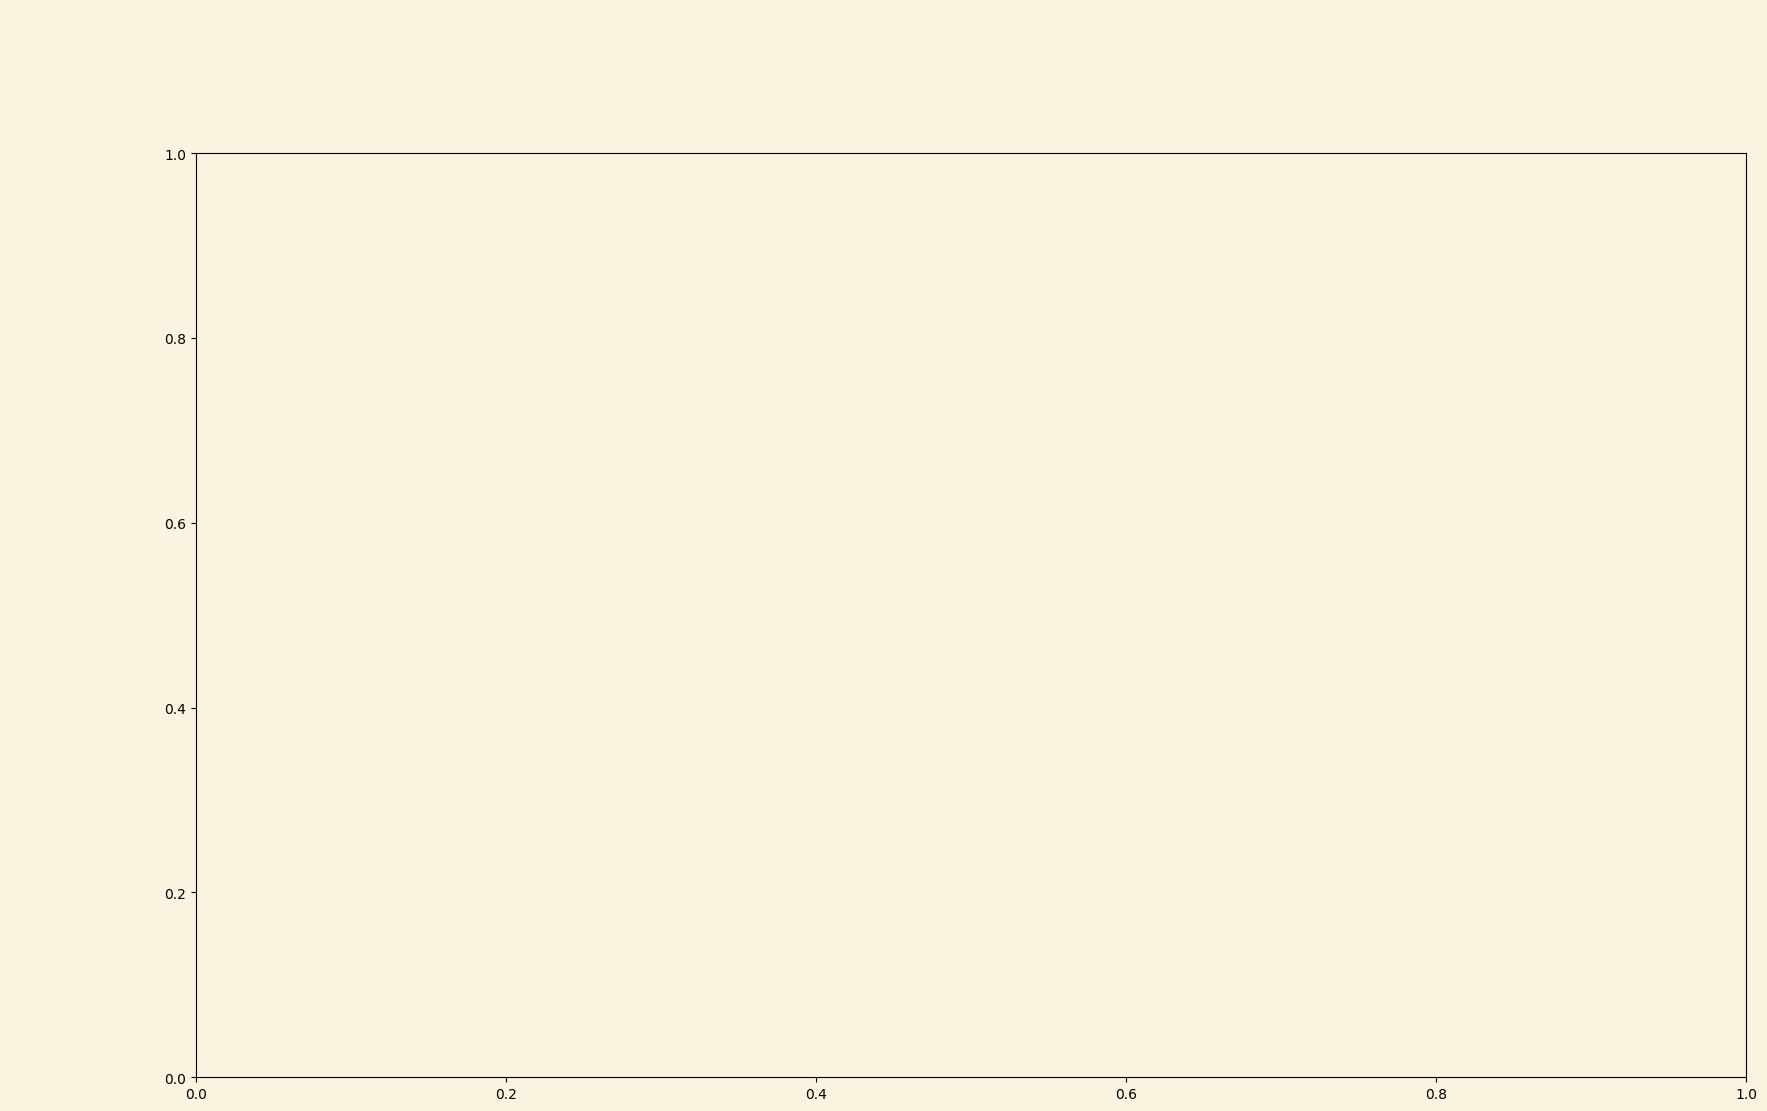

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
import requests
from matplotlib import font_manager
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
import seaborn as sns
import json
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import plotly.express as px
import os
import re
from tabulate import tabulate
from math import pi
from soccerplots.radar_chart import Radar
from mplsoccer import Radar, FontManager, grid
import matplotlib.image as mpimg
from scipy import stats
from matplotlib.patches import FancyBboxPatch, Rectangle
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import csv
import glob




''' Set the folder path where the csv files are stored: '''
folder_path = r'C:\Users\Sander\Documents\football_analytics\data\player_data\player_data\leagues'

''' Get all the csv files in the folder: '''
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')
             and (
                 '23' in f or 
                  '24' in f
                #   or '25' in f
                  )
            ]


''' Create an empty list to store the dataframes: '''
dfs = []

''' Read all the csv files in the folder: '''
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)
    
''' Combine all the dataframes into one big dataframe: '''
combined_df = pd.concat(dfs,
                        # ignore_index=True
                        )

''' Save the combined dataframe to a csv file: '''
# combined_df.to_csv(r'C:\Users\Sander\Downloads\combined_all_leagues.csv', index=False)

# combined_df = pd.read_csv(folder_path)

positions = ['gk', 'cb', 'rb', 'lb', 'cm', 'dmf', 'am', 'w', 'cf']

cm = combined_df[
    combined_df['Position'].str.contains('cm', case=False) & 
    (combined_df['Minutes played'] > 500)].reset_index(drop=False) 


# Get user input for player name
user_input_player_1 = input('Enter the first player name on the form x.x: ')
user_input_player_2 = input('Enter the second player name on the form x.x: ')


# user_input_player_1 = 'S. Nypan'
player_1 = cm[cm['Player'] == user_input_player_1]
# user_input_player_2 = 'F. Myhre'
player_2 = cm[cm['Player'] == user_input_player_2]


''' LET YOU CHOOSE THE PLAYER RECORD YOU WANT IF THERE ARE MULTIPLE RECORDS FOR THE SAME PLAYER '''
def get_player_id(percentiles_player):
    if not percentiles_player.empty:
        print("Available player records:")
        print(percentiles_player[['Player', 'Wyscout id', 'Team']])

        if len(percentiles_player) > 1:
            try:
                choice = int(input(f"Enter the number of the correct record (1-{len(percentiles_player)}): ")) - 1
                if 0 <= choice < len(percentiles_player):
                    return percentiles_player.index[choice]
                else:
                    print("Invalid choice.")
                    return None
            except ValueError:
                    print("Invalid input. Please enter a number.")
                    return None
        else:
                # If only one record is found, return its ID
            return percentiles_player.index[0]
    else:
        print("Player not found.")
        return None
    
player_id_1 = get_player_id(player_1)
player_id_2 = get_player_id(player_2)
print(f"Selected player ID: {player_id_1}")
print(f'Selected player ID: {player_id_2}')


player_1_competition = cm.loc[player_id_1, 'Competition']
player_2_competition = cm.loc[player_id_2, 'Competition']

player_1_competition = cm[cm['Competition'] == player_1_competition]
player_2_competition = cm[cm['Competition'] == player_2_competition]


percentiles_competition_1 = player_1_competition.copy()
percentiles_competition_2 = player_2_competition.copy()
zscores_competition_1 = player_1_competition.copy()
zscores_competition_2 = player_2_competition.copy()

for column in player_1_competition.select_dtypes(include=['float', 'int']).columns:
    percentiles_competition_1[column] = percentiles_competition_1[column].rank(pct=True)
    zscores_competition_1[column] = stats.zscore(zscores_competition_1[column], nan_policy='omit')

for column in player_2_competition.select_dtypes(include=['float', 'int']).columns:
    percentiles_competition_2[column] = percentiles_competition_2[column].rank(pct=True)
    zscores_competition_2[column] = stats.zscore(zscores_competition_2[column], nan_policy='omit')


percentiles_player_1 = pd.DataFrame(percentiles_competition_1.loc[player_id_1]).T
percentiles_player_2 = pd.DataFrame(percentiles_competition_2.loc[player_id_2]).T
z_scores_player_1 = pd.DataFrame(zscores_competition_1.loc[player_id_1]).T
z_scores_player_2 = pd.DataFrame(zscores_competition_2.loc[player_id_2]).T



# Check if the player exists in the DataFrame
if not percentiles_player_1.empty and not percentiles_player_2.empty and not zscores_competition_1.empty and not zscores_competition_2.empty:
    
    columns_to_drop = ['Player', 'Wyscout id', 'Team', 'Position', 'Primary position', 'Primary position, %', 'Weight', 'Height', 'Team within selected timeframe', 
                       'Market value', 'Minutes played', 'Age', 'Secondary position', 'Third position', 'Yellow cards', 'Red cards',
                       'Assists', 'xA', 'Goals', 'xG', 'Fouls suffered per 90', 'Direct free kicks on target, %', 'Penalty conversion, %', 'Corners per 90', 'Direct free kicks per 90', 
                       'PAdj Sliding tackles', 'Average long pass length, m', 'Penalties taken', 'Shots', 'Back passes per 90', 'Accurate crosses from left flank, %', 'Head goals', 'Head goals per 90',
                       'Goals per 90', 'Duels per 90', 'Sliding tackles per 90']
    # Get the percentile values for the player, excluding the 'Player' column
    top_stats_player_1 = percentiles_player_1.drop(columns = columns_to_drop, errors='ignore').T  # Transpose to have stats as rows
    top_stats_player_2 = percentiles_player_2.drop(columns = columns_to_drop, errors='ignore').T  # Transpose to have stats as rows

    top_stats_player_1 = top_stats_player_1.apply(pd.to_numeric, errors='coerce').dropna()
    top_stats_player_2 = top_stats_player_2.apply(pd.to_numeric, errors='coerce').dropna()
    
    # Get the top ten stats based on the percentile values
    top_ten_stats_player_1 = top_stats_player_1.nlargest(10, top_stats_player_1.columns[0])
    top_ten_stats_player_2 = top_stats_player_2.nlargest(10, top_stats_player_2.columns[0])
    # Display the results
    for stat, value in top_ten_stats_player_1.iterrows():
        print(f"Stat: {stat}, Percentile: {value.values[0]:.2f}")
        
    for stat, value in top_ten_stats_player_2.iterrows():
        print(f"Stat: {stat}, Percentile: {value.values[0]:.2f}")
else:
    print("Player not found.")
    



other_players_of_interest = combined_df[
    (combined_df['Position'].str.contains('w', case=False)) &
    (combined_df['Primary position'].str.contains('w', case=False)) &
    (combined_df['Minutes played'] >= 1500) &
    (combined_df['Age'] < 20) &
    (combined_df['Market value'] <= 5000000) &
    (combined_df['Successful attacking actions per 90'] >= z_scores_player_1['Smart passes per 90'].values[0]*0.7) &
    # (central_stats_cm['Shots on target, %'] >= player_of_interest_central_stats['Shots on target, %'].values[0]*0.8) &
    # (central_stats_cm['Goal conversion, %'] >= player_of_interest_central_stats['Goal conversion, %'].values[0]*0.8) &
    (combined_df['Successful dribbles, %'] >= z_scores_player_1['Progressive runs per 90'].values[0]*0.7) &
    # (central_stats_cm['Accurate passes to penalty area, %'] >= player_of_interest_central_stats['Accurate passes to penalty area, %'].values[0]*0.8) &
    (combined_df['Accelerations per 90'] >= z_scores_player_1['Through passes per 90'].values[0]*0.7) &
    (combined_df['Offensive duels won, %'] >= z_scores_player_1['Offensive duels per 90'].values[0]*0.7) &
    (combined_df['Progressive runs per 90'] >= z_scores_player_1['Successful attacking actions per 90'].values[0]*0.7) &
    # (central_stats_cm['Goals'] >= player_of_interest_central_stats['Goals'].values[0]*0.5) &
    (combined_df['Deep completions per 90'] >= z_scores_player_1['Accelerations per 90'].values[0]*0.7) 
    # (combined_df['Touches in box per 90'] >= player_of_interest_2022_2023_t['Touches in box per 90'].values[0]*0.8)
].drop_duplicates()



# position_input = input('Select position from: CF, W, AM, CM, DM, WB, CB, GK')
# if position_input == 'CF':
#     params = ['Goals per 90', 'xG', 'Non-penalty goals per 90', 'Shots on target, %', 'Goal conversion, %', 
#               'Successful attacking actions per 90', 'Progressive runs per 90', 'Touches in box per 90']
# elif position_input == 'W' or position_input == 'AM':
#     params = ['Successful attacking actions per 90','Successful dribbles, %', 'Accelerations per 90', 
#                 'Offensive duels won, %', 'Progressive runs per 90', 'Touches in box per 90']
# elif position_input == 'CM':
    # params = ['Successful attacking actions per 90','Successful dribbles, %', 'Accelerations per 90', 
    #           'Progressive runs per 90', 'Touches in box per 90']
    
    
    
params= top_ten_stats_player_1.index
params_2 = top_ten_stats_player_2.index

ranges = []
min_val = []
max_val = []
for x in params:
    min_val.append(player_1_competition[x].min())
    max_val.append(player_1_competition[x].max())
    # ranges.append((min_val - (0.25 * min_val), max_val + (0.25 * max_val)))
    
min_val2 = []
max_val2 = []
for x in params_2:
    min_val2.append(player_2_competition[x].min())
    max_val2.append(player_2_competition[x].max())

radar = Radar(params, min_val, max_val,
            # whether to round any of the labels to integers instead of decimal places
            round_int=[False]*len(params),
            num_rings=4,  # the number of concentric circles (excluding center circle)
            # if the ring_width is more than the center_circle_radius then
            # the center circle radius will be wider than the width of the concentric circles
            ring_width=1, center_circle_radius=1)      

radar2 = Radar(params_2, min_val2, max_val2,
            # whether to round any of the labels to integers instead of decimal places
            round_int=[False]*len(params_2),
            num_rings=4,  # the number of concentric circles (excluding center circle)
            # if the ring_width is more than the center_circle_radius then
            # the center circle radius will be wider than the width of the concentric circles
            ring_width=1, center_circle_radius=1)       
        
URL1 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-Regular.ttf')
serif_regular = FontManager(URL1)
URL2 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-ExtraLight.ttf')
serif_extra_light = FontManager(URL2)
URL3 = ('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
        'RubikMonoOne-Regular.ttf')
rubik_regular = FontManager(URL3)
URL4 = 'https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf'
robotto_thin = FontManager(URL4)
URL5 = ('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
        'RobotoSlab%5Bwght%5D.ttf')
robotto_bold = FontManager(URL5)

consolas = font_manager.FontProperties(fname=r'C:\Users\Sander\Downloads\Consolas.ttf')

font = font_manager.FontProperties(fname=r'C:\Users\Sander\Downloads\Akzidenz-Grotesk-Font\Akzidenz Grotesk Font\Akzidenz-grotesk-bold.ttf')



def save_figure(fig, folder_path, filename):
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
          # Create the full file path
    file_path = os.path.join(folder_path, filename)

    # Save the figure
    fig.savefig(file_path)
    # plt.close(fig)  # Close the figure after saving
    




''' RADAR PLOT 1'''
def plot_radar_1():
        
    compare = cm.loc[(cm['Player'] == user_input_player_1) & (cm.index == player_id_1), params].values[0]

    # creating the figure using the grid function from mplsoccer:
    fig, axs = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                    title_space=0, endnote_space=0, grid_key='radar', axis=False)

    # plot the radar
    radar.setup_axis(ax=axs['radar'], facecolor='#FAF3E0')
    rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='#ffb2b2', edgecolor='#39353f', lw=1.5)
    radar_output = radar.draw_radar(compare, ax=axs['radar'],
                                            kwargs_radar={'facecolor': '#FF1493', 'alpha': 0.6},
                                            kwargs_rings={'facecolor': '#FF1493', 'alpha': 0.6})
    radar_poly, rings_outer, vertices1 = radar_output
    range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=30, color='black',
                                        fontproperties=consolas)
    param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=30, color='black',
                                        fontproperties=consolas)
    axs['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
                        c='#FF1493', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)

    # adding the endnote and title text (these axes range from 0-1, i.e. 0, 0 is the bottom left)
    # Note we are slightly offsetting the text from the edges by 0.01 (1%, e.g. 0.99)
    # endnote_text = axs['endnote'].text(0.99, 0.5, '@Fotbadlstat on X',
    #                                 color='#a3c2a8', fontproperties=rubik_regular.prop,
    #                                 fontsize=13, ha='right', va='center')
    # title1_text = axs['title'].text(0.01, 0.65, percentiles_player_1['Player'].values[0], fontsize=25,
    #                                 fontproperties=robotto_bold.prop,
    #                                 ha='left', va='center', color='#FF1493')
    # title2_text = axs['title'].text(0.01, 0.25, f'{percentiles_player_1['Team within selected timeframe'].values[0]} | {cm.loc[cm['Player'] == user_input_player_1, 'Age'].values[0]} years old', fontsize=20,
    #                                 fontproperties=robotto_thin.prop,
    #                                 ha='left', va='center', color='#FF1493')
    # title3_text = axs['title'].text(0.99, 0.65, f'Primary position: {percentiles_player_1['Primary position'].values[0]}', fontsize=25,
    #                                 fontproperties=robotto_bold.prop,
    #                                 ha='right', va='center', color='#FF1493')
    # title4_text = axs['title'].text(0.99, 0.25, f'Minutes played: {cm.loc[cm['Player'] == user_input_player_1, 'Minutes played'].values[0]}', fontsize=20,
    #                                 fontproperties=robotto_thin.prop,
    #                                 ha='right', va='center', color='#FF1493')

    fig.set_facecolor('#FAF3E0')
    
    
    # player_folder = f"{percentiles_player_1['Player'].values[0]}_compare"
    # folder_path = os.path.join(r'C:\Users\Sander\Documents\football_analytics\scouting', player_folder)

    # # Create the filename and save the figure
    # filename = f"{percentiles_player_1['Player'].values[0]} vs {percentiles_player_2['Player'].values[0]}.png"
    
    # # Save the figure and ensure folder exists
    # save_figure(fig, folder_path, filename)

    return fig, axs



''' RADAR PLOT 2'''
def plot_radar_2():

    compare2 = cm.loc[(cm['Player'] == user_input_player_2) & (cm.index == player_id_2), params_2].values[0]


    # creating the figure using the grid function from mplsoccer:
    fig2, axs2 = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                    title_space=0, endnote_space=0, grid_key='radar2', axis=False)

    # plot the radar
    radar2.setup_axis(ax=axs2['radar2'], facecolor='#FAF3E0')
    rings_inner2 = radar2.draw_circles(ax=axs2['radar2'], facecolor='#ffb2b2', edgecolor='#39353f', lw=1.5)
    radar_output2 = radar2.draw_radar(compare2, ax=axs2['radar2'],
                                            kwargs_radar={'facecolor': '#FF1493', 'alpha': 0.6},
                                            kwargs_rings={'facecolor': '#FF1493', 'alpha': 0.6})
    radar_poly, rings_outer, vertices2 = radar_output2
    range_labels = radar2.draw_range_labels(ax=axs2['radar2'], fontsize=30, color='black',
                                        fontproperties=consolas)
    param_labels = radar2.draw_param_labels(ax=axs2['radar2'], fontsize=30, color='black',
                                        fontproperties=consolas)
    axs2['radar2'].scatter(vertices2[:, 0], vertices2[:, 1],
                        c='#FF1493', edgecolors='#6d6c6d', marker='o', s=150, zorder=2)

    # adding the endnote and title text (these axes range from 0-1, i.e. 0, 0 is the bottom left)
    # Note we are slightly offsetting the text from the edges by 0.01 (1%, e.g. 0.99)
    # endnote_text = axs['endnote'].text(0.99, 0.5, '@Fotbadlstat on X',
    #                                 color='#a3c2a8', fontproperties=rubik_regular.prop,
    #                                 fontsize=13, ha='right', va='center')
    # title1_text = axs['title'].text(0.01, 0.65, percentiles_player_1['Player'].values[0], fontsize=25,
    #                                 fontproperties=robotto_bold.prop,
    #                                 ha='left', va='center', color='#FF1493')
    # title2_text = axs['title'].text(0.01, 0.25, f'{percentiles_player_1['Team within selected timeframe'].values[0]} | {cm.loc[cm['Player'] == user_input_player_1, 'Age'].values[0]} years old', fontsize=20,
    #                                 fontproperties=robotto_thin.prop,
    #                                 ha='left', va='center', color='#FF1493')
    # title3_text = axs['title'].text(0.99, 0.65, f'Primary position: {percentiles_player_1['Primary position'].values[0]}', fontsize=25,
    #                                 fontproperties=robotto_bold.prop,
    #                                 ha='right', va='center', color='#FF1493')
    # title4_text = axs['title'].text(0.99, 0.25, f'Minutes played: {cm.loc[cm['Player'] == user_input_player_1, 'Minutes played'].values[0]}', fontsize=20,
    #                                 fontproperties=robotto_thin.prop,
    #                                 ha='right', va='center', color='#FF1493')

    fig2.set_facecolor('#FAF3E0')
    
    
    # player_folder = f"{percentiles_player_1['Player'].values[0]}_compare"
    # folder_path = os.path.join(r'C:\Users\Sander\Documents\football_analytics\scouting', player_folder)

    # # Create the filename and save the figure
    # filename = f"{percentiles_player_1['Player'].values[0]} vs {percentiles_player_2['Player'].values[0]}.png"
    
    # # Save the figure and ensure folder exists
    # save_figure(fig2, folder_path, filename)

    return fig2, axs2





# Main plotting function
def main_plot():
    # Create the main figure for both players
    fig, ax = plt.subplots(figsize=(20, 12))
    fig.set_facecolor('#FAF3E0')
    ax.set_facecolor('#FAF3E0')

    'PLAYER 1 PICTURE AND LOGO'
    ax_p1_img = fig.add_axes([0.032, 0.8, 0.1, 0.2])
    # ax_p1_logo_img = fig.add_axes([0.2, 0.8, 0.1, 0.2])
    ax_p1_img.axis('off')
    # ax_p1_logo_img.axis('off')
    # player1_image = mpimg.imread(fr'C:\Users\Sander\Downloads\{user_input_player_1}.png')
    image_paths = glob.glob(fr'C:\Users\Sander\Documents\football_analytics\data\player_images\eliteserien_2024\{user_input_player_1}.png', recursive=True)
    if image_paths:
        image_path = image_paths[0]  # If found, take the first match
        player1_image = mpimg.imread(image_path)
        print(f"Image found: {image_path}")
        ax_p1_img.imshow(player1_image)
    else:
        print("Image not found.")
    # player1_logo = mpimg.imread(fr'C:\Users\Sander\Downloads\{percentiles_player_1['Team within selected timeframe'].values[0]}_logo.png')
    # ax_p1_img.imshow(player1_image)
    # ax_p1_logo_img.imshow(player1_logo)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.text(0.085, 0.79, f'{user_input_player_1} - key stats in percentile (z-scores to the right):', fontsize=12, ha='center', fontproperties=consolas)

    '''PLAYER 1 BAR CHART'''
    ax_p1_bars = fig.add_axes([0.1, 0.58, 0.05, 0.2])
    for i, (stat, percentile) in enumerate(top_ten_stats_player_1.itertuples()):
        ax_p1_bars.barh(stat, percentile, color='green', edgecolor='black')
        ax_p1_bars.text(top_ten_stats_player_1.values[0] - 0.6, stat, f'{percentile:.2f}', va='center', ha='left', color='black', fontproperties=consolas)
        ax_p1_bars.text(top_ten_stats_player_1.values[0] + 0.8, stat, f'+{z_scores_player_1[stat].values[0]:.2f} std', va='center', ha='right', color='black', fontproperties=consolas)
    ax_p1_bars.set_xlim(0, 1)
    ax_p1_bars.invert_yaxis()
    ax_p1_bars.spines['top'].set_visible(False)
    ax_p1_bars.spines['bottom'].set_visible(False)
    ax_p1_bars.spines['left'].set_visible(False)
    ax_p1_bars.spines['right'].set_visible(False)
    ax_p1_bars.set_facecolor('#FAF3E0')


    '''PLAYER 2 PICTURE AND LOGO'''
    ax_p2_img = fig.add_axes([0.70, 0.8, 0.1, 0.2])
    # ax_p2_logo_img = fig.add_axes([0.6, 0.85, 0.05, 0.1])
    ax_p2_img.axis('off')
    # ax_p2_logo_img.axis('off')
    # player2_image = mpimg.imread(fr'C:\Users\Sander\Downloads\{user_input_player_2}.png')
    image_paths = glob.glob(fr'C:\Users\Sander\Documents\football_analytics\data\player_images\eliteserien_2024\{user_input_player_1}.png', recursive=True)
    if image_paths:
        image_path = image_paths[0]  # If found, take the first match
        player2_image = mpimg.imread(image_path)
        print(f"Image found: {image_path}")
        ax_p2_img.imshow(player2_image)
    else:
        print("Image not found.")
    # player2_logo = mpimg.imread(fr'C:\Users\Sander\Downloads\Bodø_logo.png')
    # ax_p2_img.imshow(player2_image)
    # ax_p2_logo_img.imshow(player2_logo)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.text(0.75, 0.79, f'{user_input_player_2} - key stats in percentile (z-scores to the left):', fontsize=12, ha='center', fontproperties=consolas)

    '''PLAYER 2 BAR CHART'''
    ax_p2_bars = fig.add_axes([0.7, 0.58, 0.05, 0.2])
    for i, (stat, percentile) in enumerate(top_ten_stats_player_2.itertuples()):
        ax_p2_bars.barh(stat, percentile, color='green', edgecolor='black')
        ax_p2_bars.text(top_stats_player_2.values[0] + 0.4, stat, f'{percentile:.2f}', va='center', ha='left', color='black', fontproperties=consolas)
        ax_p2_bars.text(top_ten_stats_player_2.values[0] + 0.2, stat, f'+{z_scores_player_2[stat].values[0]:.2f} std', va='center', ha='right', color='black', fontproperties=consolas)
    ax_p2_bars.set_xlim(0, 1)
    ax_p2_bars.invert_yaxis()
    ax_p2_bars.invert_xaxis()
    ax_p2_bars.spines['top'].set_visible(False)
    ax_p2_bars.spines['bottom'].set_visible(False)
    ax_p2_bars.spines['right'].set_visible(False)
    ax_p2_bars.spines['left'].set_visible(False)
    ax_p2_bars.yaxis.tick_right()
    ax_p2_bars.set_facecolor('#FAF3E0')


    ''' RADAR PLOT PLAYER 1'''
    radar_fig, radar_axs = plot_radar_1()  # Call your radar plotting function
    radar_fig.canvas.draw()  # Ensure the radar figure is drawn before using its buffer
    radar_ax = fig.add_axes([-0.1, 0.1, 0.4, 0.4])  # Adjust [left, bottom, width, height] as needed
    radar_ax.imshow(radar_fig.canvas.buffer_rgba())  # Render radar plot into the new ax
    for ax in radar_axs.values():
        ax.remove()  # Remove original axes if needed
    radar_ax.spines['top'].set_visible(False)
    radar_ax.spines['bottom'].set_visible(False)
    radar_ax.spines['left'].set_visible(False)
    radar_ax.spines['right'].set_visible(False)
    radar_ax.xaxis.set_ticks([])
    radar_ax.yaxis.set_ticks([])
    
    
    
    ''' RADAR PLOT PLAYER 2'''
    radar_fig_2, radar_axs_2 = plot_radar_2()  # Call your radar plotting function
    radar_fig_2.canvas.draw()  # Ensure the radar figure is drawn before using its buffer
    radar_ax_2 = fig.add_axes([0.55, 0.1, 0.4, 0.4])  # Adjust [left, bottom, width, height] as needed
    radar_ax_2.imshow(radar_fig_2.canvas.buffer_rgba())  # Render radar plot into the new ax
    for ax2 in radar_axs_2.values():
        ax2.remove()  # Remove original axes if needed
    radar_ax_2.spines['top'].set_visible(False)
    radar_ax_2.spines['bottom'].set_visible(False)
    radar_ax_2.spines['left'].set_visible(False)
    radar_ax_2.spines['right'].set_visible(False)
    radar_ax_2.xaxis.set_ticks([])
    radar_ax_2.yaxis.set_ticks([])

   
    
    
    
   
    ''' THE TABLE'''
    tabell = fig.add_axes([0.27, 0.57, 0.3, 0.25])
    
    tabell_values = ['Player', 'Matches played', 'Minutes played', 'Age', 'Competition', 'Team',
                 'Primary position', 'Secondary position', 'Contract expires', 'Market value', 'Goals', 'Assists']
    tabell_values.reverse()
    player_data = cm.loc[(cm['Player'] == user_input_player_1) & (cm.index == player_id_1), tabell_values].values.flatten()
    player_data2 = cm.loc[(cm['Player'] == user_input_player_2) & (cm.index == player_id_2), tabell_values].values.flatten()

    table_data = list(zip(tabell_values, player_data))
    table_data_2 = list(player_data2)

    tabell.spines['top'].set_visible(False)
    tabell.spines['bottom'].set_visible(False)
    tabell.spines['left'].set_visible(False)
    tabell.spines['right'].set_visible(False)
    tabell.xaxis.set_ticks([])
    tabell.yaxis.set_ticks([])
    tabell.set_facecolor('#FAF3E0')

    for i, (label, value) in enumerate(table_data):
        bbox = FancyBboxPatch((0, i * 0.1), 1, 0.1, boxstyle="round,pad=0.05", color='#FAF3E0', ec='none')
        tabell.add_patch(bbox)
        tabell.text(0.25, i * 0.1 + 0.05, label, ha='center', va='center', fontsize=11, fontproperties=consolas)
        tabell.text(0.70, i * 0.1 + 0.05, value, ha='center', va='center', fontsize=11, fontproperties=consolas)

    for i, value2 in enumerate(table_data_2):
        tabell.text(1.15, i * 0.1 + 0.05, value2, ha='center', va='center', fontsize=11, fontproperties=consolas)

    tabell.plot([0.5, 0.5], [0, len(table_data) * 0.1], color='black', linewidth=1)
    tabell.plot([0.95, 0.95], [0, len(table_data) * 0.1], color='black', linewidth=1)
    for i in range(len(table_data_2)):
        tabell.plot([-0.05, 1.4], [i * 0.1, i * 0.1], color='black', linewidth=1)
    
    outline = Rectangle((-0.05, 0), 1.45, len(table_data) * 0.1, linewidth=2, edgecolor='black', facecolor='none')
    tabell.add_patch(outline)







 

  
    ''' HEATMAPS'''
    def format_player_name(full_name):
        parts = full_name.split()  # Split the name into parts
        first_initial = parts[0][0]  # Get the first initial
        last_name = parts[-1]  # Get the last name
        return f"{first_initial}. {last_name}"

    def load_player_data():
        player_data = []
        with open(rf'C:\Users\Sander\Documents\football_analytics\data\player_ids_and_names\eliteserien_2024\player_ids_and_names_eliteserien_2024.csv', mode='r', encoding='utf-8') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header
            player_data = [(row[0], format_player_name(row[1])) for row in reader]
        return player_data

    def plot_heatmap_for_player(player_name, player_dict, headers, fig, ax_position):
        if player_name in player_dict:
            player_id = player_dict[player_name]
            url = f"https://www.sofascore.com/api/v1/player/{player_id}/unique-tournament/20/season/57322/heatmap/overall"

            response = requests.get(url, headers=headers)
            data = response.json()

            if 'points' in data:
                x_coords = [event['x'] for event in data['points']]
                y_coords = [event['y'] for event in data['points']]

                pitch_length = 100
                y_coords = pitch_length - np.array(y_coords)  # Invert y-coordinates

                # Use the existing figure (fig) and add the heatmap at the provided position
                heatmap_ax = fig.add_axes(ax_position)  # Position heatmap in the main plot
                pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#FAF3E0')
                pitch.draw(ax=heatmap_ax)

                # Bin the data and create the heatmap
                bin_statistic = pitch.bin_statistic(x_coords, y_coords, statistic='count', bins=(6, 5), normalize=True)
                pitch.heatmap(bin_statistic, ax=heatmap_ax, cmap='Reds', edgecolor='#f9f9f9')

                # Add labels for values
                path_eff = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()]
                labels = pitch.label_heatmap(bin_statistic, color='#000000', fontsize=12,
                                            ax=heatmap_ax, ha='center', va='center',
                                            str_format='{:.0%}', path_effects=path_eff)

                heatmap_ax.set_title(f"Heatmap for {player_name}")
            else:
                print(f"No data for player ID: {player_id} - {player_name}")
        else:
            print(f"Player name not found: {player_name}")

    # Headers for the request
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36"}

    # Load player data and create dictionary
    player_data = load_player_data()
    player_dict = {name: player_id for player_id, name in player_data}

    # List of player names to plot
    players_to_plot = [user_input_player_1, user_input_player_2]  # Replace with actual player names

  
    heatmap_positions = [
        [0.17, 0.13, 0.35, 0.35],  # Position for the first player's heatmap
        [0.32, 0.13, 0.35, 0.35]  # Position for the second player's heatmap
    ]

    # Loop through the players and plot their heatmaps on the existing figure
    for i, player_name in enumerate(players_to_plot):
        plot_heatmap_for_player(player_name, player_dict, headers, fig, heatmap_positions[i])



    
    plt.show()



    
    


main_plot()



